Bandit network with 1 arm

In [1]:
import os
import nxsdk.api.n2a as nx
import numpy as np
import matplotlib.pyplot as plt
from nxsdk.graph.monitor.probes import *
from nxsdk.graph.processes.phase_enums import Phase

In [2]:
import re

In [3]:
import matplotlib.pyplot as plt

In [4]:
def set_params_file(numArms, neuronsPerArm):
    filename = os.getcwd()+'/parameters.h'
    
    with open(filename) as f:
        data = f.readlines()
        
    f = open(filename, "w")
    for line in data:

        #update numarms
        m = re.match(r'^#define\s+NUMARMS', line)
        if m is not None:
            line = '#define NUMARMS ' + str(numArms) + '\n'

        #update neuronsperarm
        m = re.match(r'^#define\s+NEURONSPERARM', line)
        if m is not None:
            line = '#define NEURONSPERARM ' + str(neuronsPerArm) + '\n'

        f.write(line)
        
    f.close()

In [5]:
def create_network(numArms, neuronsPerArm, epochs, weights, probabilities, votingEpoch=128):
    assert len(weights) == numArms, "Must provide number of weights equal to number of arms."
    assert len(probabilities) == numArms, "Must provide probability for each arm's reward."
    for p in probabilities:
        assert p in range(0,100+1), "Probabilities must be represented as int from 0-100."
    totalNeurons = neuronsPerArm * numArms

    #create the network
    net = nx.NxNet()
    #set up the noisy source neuron prototype
    p_2Fire = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=4,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=0,

                            enableNoise=0,
                            randomizeVoltage=0,
                            randomizeCurrent=0,
                            noiseMantAtCompartment=0,
                            noiseExpAtCompartment=0,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=0)
    
    #set up the integrative prototype
    p_Compare = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=100,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=2048,

                            enableNoise=1,
                            randomizeVoltage=0,
                            randomizeCurrent=1,
                            noiseMantAtCompartment=0,
                            noiseExpAtCompartment=7,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=1)
    
    #TEST
    p_Integrator = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=254,
                            compartmentVoltageDecay=0,
                            compartmentCurrentDecay=4095,

                            enableNoise=0,
                            randomizeVoltage=0,
                            randomizeCurrent=1,
                            noiseExpAtCompartment=7,
                            functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                             logicalCoreId=1)

    #set up the learning rule that will control weight changes
    lr = net.createLearningRule(dw='u0*r1',
                                r1Impulse=2,
                                r1TimeConstant=1,
                                tEpoch=2,
                                printDebug=True)
                                #TODO - can inc/dec weight based on reward

    #create the connections which drive the integrator
    exh_connx = nx.ConnectionPrototype(weight=2,
                                    delay=0,
                                    enableLearning=1,
                                    learningRule=lr,
                                    numTagBits=8,
                                    signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
    
    conn0 = nx.ConnectionPrototype(weight=255,
                                    delay=0,
                                    signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
    
    inh_connx = nx.ConnectionPrototype(weight=2,
                                    delay=0,
                                    signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

    
    #TEST
    spikeGenReward = net.createSpikeGenProcess(1)
    spikeGenReward.addSpikes([0], [[1]])
    
    rtracer = net.createCompartment(prototype=p_Integrator)
    spikeGenReward.connect(rtracer, prototype=conn0)
    
    #create inhibitory, excitatory, and integrative compartment groups
    inhDriver = net.createCompartmentGroup(size=neuronsPerArm, prototype=p_2Fire)
    exhDriver = net.createCompartmentGroup(size=neuronsPerArm, prototype=p_2Fire)
    comparator = net.createCompartmentGroup(size=neuronsPerArm, prototype=p_Compare)

    exhGrp = exhDriver.connect(comparator,
                  prototype=exh_connx,
                  weight= np.repeat(weights, neuronsPerArm) * np.identity(neuronsPerArm),
                 connectionMask=np.identity(neuronsPerArm))

    inhGrp = inhDriver.connect(comparator,
                  prototype=inh_connx,
                  weight=-50*np.identity(neuronsPerArm),
                 connectionMask=np.identity(neuronsPerArm))
    
    rconnx = rtracer.connect(lr.reinforcementChannel, prototype=exh_connx)
    rmon = rconnx.probe(nx.ProbeParameter.REWARD_TRACE)


    #setup the spike monitor
    customSpikeProbeCond = SpikeProbeCondition(tStart=10000000)
    monitors = comparator.probe(nx.ProbeParameter.SPIKE, customSpikeProbeCond)
    wmon = (exhGrp.probe(nx.ProbeParameter.SYNAPSE_WEIGHT))
    
    
    
    #compile the network so we can add channels for the SNIPs
    compiler = nx.N2Compiler()
    board = compiler.compile(net)
    #get the location of the reinforcementChannel
    rc_loc = net.resourceMap.reinforcementChannel(0)

    #setup the management SNIP to calculate rewards and choose numArms
    includeDir = os.getcwd()
    learning = board.createSnip(Phase.EMBEDDED_MGMT,
                                 includeDir=includeDir,
                                 cFilePath = includeDir + "/management.c",
                                 funcName = "run_cycle",
                                 guardName = "check")

    #create a channel to communicate with the Lakemont what the probability of each arm is
    #have to transfer the number of arms, neurons per arm, and the probeID listening to each neuron
    setupChannel = board.createChannel(b'setupChannel', "int", numArms + 5 + totalNeurons)
    setupChannel.connect(None, learning)
    #setup the channels which will transfer the chosen arm
    dataChannel = board.createChannel(b'dataChannel', "int", (epochs+1))
    dataChannel.connect(learning, None)
    #and the reward for that arm
    rewardChannel = board.createChannel(b'rewardChannel', "int", (epochs+1))
    rewardChannel.connect(learning, None)
    
    #write the parameters into the file since we can't use dynamic allocation ;_;
    set_params_file(numArms, neuronsPerArm)
    
    #boot the board
    board.startDriver()
    #set the length of the voting period
    setupChannel.write(1, [votingEpoch])
    #write the location of the reinforcementChannel we can send reward events to
    #done in for loop as not sure how tuple vs list might affect writing...
    for i in range(4):
        setupChannel.write(1, [rc_loc[0][i]])
    #set the reward probabilities
    setupChannel.write(numArms, probabilities)
    
    
    #and the map for probeid <-> neuron
    pids = [monitors[0].probes[i].n2Probe.counterId for i in range(neuronsPerArm)] 
    setupChannel.write(1, [pids[0]])

    return (net, board, monitors, dataChannel, rewardChannel, wmon, rmon)

In [6]:
#probs = [90, 10, 10, 10, 10]
numArms = 1
probs = 50 * np.ones(numArms, dtype='int')
#weights = np.linspace(50, 100, num=5, dtype='int')
weights = 100*np.ones(numArms, dtype='int')
neuronsPerArm = 1
votingEpoch = 128
totalNeurons = numArms * neuronsPerArm
epochs = 10

In [7]:
(net, board, mons, dchannel, rchannel, ws, rmon) = create_network(numArms, neuronsPerArm, epochs, weights, probs, votingEpoch=votingEpoch)
board.run(votingEpoch*epochs+1)

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:46279
INFO:DRV:      Host server up..............Done 0.19s


/homes/wolin/python3_venv/lib/python3.5/site-packages/ipykernel_launcher.py:141: NxDeprecationWarning: startDriver is being deprecated. Use start instead.


INFO:DRV:      Compiling Embedded snips....Done 0.39s
INFO:DRV:      Encoding axons/synapses.....Done 2.45ms
INFO:HST:  Args chip=0 cpu=0 /homes/wolin/python3_venv/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1573770549.2456377/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=2 
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Encoding probes.............Done 0.92ms
INFO:DRV:      Transferring probes.........Done 3.11ms
INFO:DRV:      Configuring registers.......Done 8.55ms
INFO:DRV:      Transferring spikes.........Done 3.88ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Executing...................Done 0.09s
INFO:DRV:      Processing timeseries.......Done 0.03s
INFO:DRV:  Executor: 1281 timesteps........Done 0.15s


In [8]:
data = dchannel.read(epochs)

In [9]:
rewards = rchannel.read(epochs)

In [10]:
board.disconnect()

INFO:HST:  chip=0 cpu=0 halted, status=0x0


In [11]:
data

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
rewards

[1, 0, 1, 1, 0, 0, 0, 1, 0, 1]

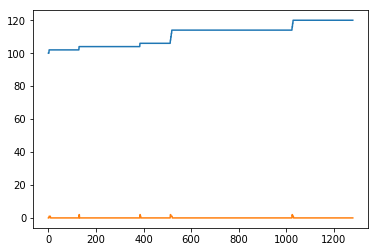

In [13]:
plt.figure()
plt.plot(ws[0][0].data)
plt.plot(rmon[0].data)

In [14]:
w0d = np.diff(np.array(ws[0][0].data))

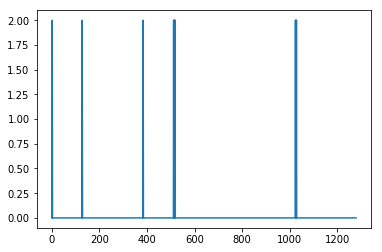

In [15]:
plt.plot(w0d)

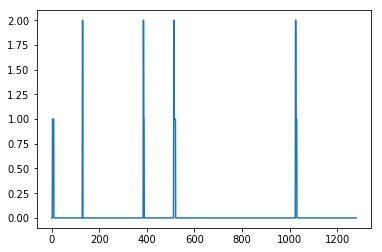

In [16]:
plt.plot(rmon[0].data)

In [17]:
np.sum(rmon[0].data)

34

In [18]:
net.resourceMap.reinforcementChannel(0)

[(1, 0, 1, 0)]

In [19]:
net.resourceMap.inputAxon(0)

[(1, 0, 1, 0)]

In [20]:
net.resourceMap.inputAxonMap

In [21]:
net.resourceMap.inputAxonMap

In [22]:
np.unique(w0d)

array([0, 2])

In [23]:
ind1 = np.where(np.array(data) == 0)

In [24]:
np.mean(np.array(rewards)[ind1])

0.5

In [25]:
ind2 = np.where(np.array(data) != 0)

In [26]:
np.mean(np.array(rewards)[ind2])

/homes/wolin/python3_venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/homes/wolin/python3_venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

(array([10.,  0.,  0.,  0.,  0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

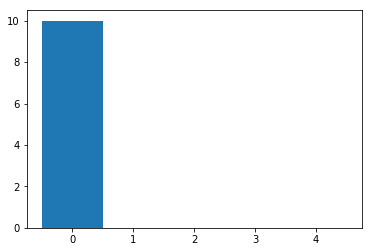

In [27]:
plt.hist(data, bins=np.arange(0,6)-0.5)